## Part A

Write MATLAB code that generates samples from this distribution. 

Plot the distribution of $r$ for a single draw of $x$ as a histogram (i.e., generate a single random
vector $x$ and use this to draw multiple samples of $r|x$ to generate the histogram). Try the same
with drawing different $x$ repeatedly.

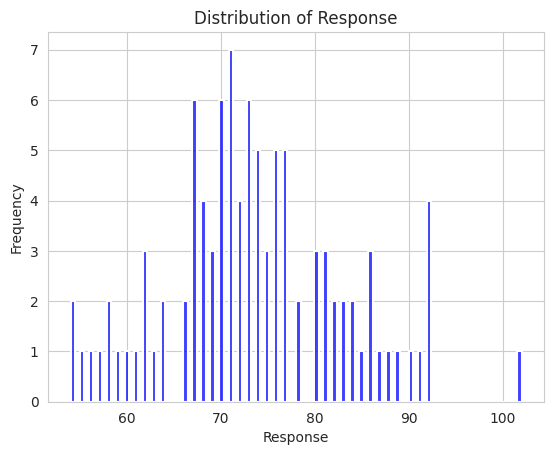

In [1]:
import seaborn as sns
from sthom215_problem_1_ex_2 import Neuron
import seaborn as sns

num_nerurons = 1
neuron = Neuron(100, mu=0, sigma=1)
# Simulate the neuron by using returned intesnity to simulate poisson spikes
resp = neuron.spiking()
import matplotlib.pyplot as plt

# Set the style and color palette
sns.despine()
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Plot the histogram
sns.histplot(resp, bins=100, kde=False, color="b", edgecolor="w", linewidth=1.5)

# Add labels and title
plt.xlabel("Response")
plt.ylabel("Frequency")
plt.title("Distribution of Response")

# Show the plot
plt.show()


## Part B

Now generate a single response draw for each of M different stimuli $ x_m $, $ m = 1, ..., M $,
where M should be a parameter in your code that is easily adjustable. The response vector should
now be an $ M $ dimensional vector $ r $ ∈ $ \mathbb{R}^M $ with a corresponding matrix $ X = [x_1, ..., x_M] $ containing
all of your generated stimuli. Often in higher dimensional settings we linearize models, in this
case assuming that $ r \approx Xg $ with added independent, identically distributed (i.i.d.) Gaussian
noise. Set up a probabilistic relationship (likelihood) of $ r $ conditioned on $ g $ under a Gaussian
noise assumption. Specifically, assume that $ r = Xg + \epsilon $ where $ \epsilon $ is a mean-zero, Gaussian noise
vector with variance $ \sigma^2I $. Use the likelihood derived to set up a maximum likelihood inference of
$ g $ given the responses and stimuli (hint: think least-squares). 

In [2]:
import numpy as np
import numpy.linalg as la
from sthom215_problem_1_ex_2 import Neuron

num_nerurons = 200
n_trials = 100
neurons =  Neuron(num_nerurons, n_trials, mu=0, sigma=1)
resp_m = neurons.activity()
stimuli_m = neurons.stimuli

true_g = neurons.get_tuning_curve(neurons.n_trials)
r_noise = np.dot(stimuli_m , true_g) + np.random.normal(0, 0.1, resp_m.shape[0])
lsqr_g = la.lstsq(stimuli_m, r_noise, rcond=None)[0]

print("tuning curve: ", lsqr_g.shape)

tuning curve:  (100,)


In [3]:
ml_g = stimuli_m.mean(axis=0)

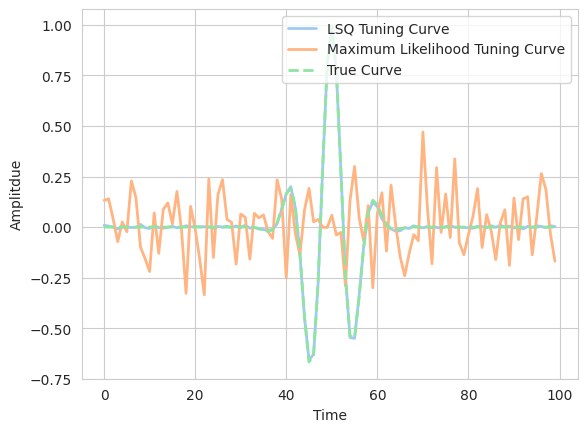

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca()

f1 = ax.plot(lsqr_g, linewidth=2.0, label="LSQ Tuning Curve")
f2 = ax.plot(ml_g, linewidth=2.0, label="Maximum Likelihood Tuning Curve")
f3 = ax.plot(true_g, linestyle = '--', linewidth=2.0, label="True Curve")

ax.legend()

ax.set_xlabel("Time")
ax.set_ylabel("Amplitdue")

plt.show()


### How close is the estimate of $g$ to the real $g$

It is very close in the least squares sense after linearization. 

## Part C
Now use the actual known likelihood (in this case) to estimate $ g $ by setting up an optimization program using likelihood defined above. You should focus on defining the minimization program and then using the fminunc function in MATLAB.
Infer the tuning curve using $ M = N $ samples. How accurate are the curves? What about for $ M = 2N $? $ M = N/2 $? Plot the estimates from Part C and Part B together. What do you notice about the estimates as the number of samples gets large?


In [19]:
from scipy.optimize import minimize
import seaborn as sns

N = 100
num_nerurons = [N//2, N, 2*N]
resultsMLList = []

for num_neuron in num_nerurons:
    n_trials = 100
    neurons =  Neuron(num_neuron, n_trials, mu=0, sigma=1)
    true_g = neuron.get_tuning_curve(neuron.n_trials)


    def obj(g,X,r):
        lam = np.exp(X @ g)
        return -r.T @ np.log(lam) + lam.sum() 

    # Minimize the cost function
    resp_m = neurons.activity()
    stimuli_m = neurons.stimuli

    #g_init = np.random.normal(0, 1, (neurons.n_trials,))
    g_init = np.zeros_like(true_g)

    opt = {'disp': True, 'maxiter': 1000, 'gtol': 1e-9}
    resultML = minimize(fun = obj, 
                    x0=g_init, 
                    args=(stimuli_m, resp_m), 
                    method='BFGS',
                    options = opt)

    resultsMLList.append(resultML.x)


         Current function value: -689547.967778
         Iterations: 1000
         Function evaluations: 114130
         Gradient evaluations: 1130


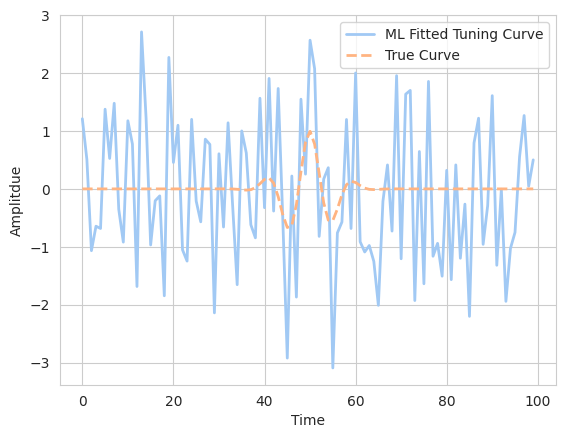

In [21]:
fig = plt.figure()
ax = fig.gca()

for resultML, num_neuron in zip(resultsMLList, num_nerurons): 
    title = f"ML Fitted Tuning Curve N = {num_neuron} neurons"
    sns.lineplot(resultML, linewidth=2.0, label=title, ax=ax)
    sns.lineplot(true_g, linestyle = '--', linewidth=2.0, label="True Curve", ax=ax)
    ax.set_xlabel("time")
    ax.set_ylabel('ampltidue')

    ax.legend()

    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitdue")

    plt.show()

## Part D
Adding in priors: Now let’s add some prior knowledge about the tuning curve. For the
Gaussian case, add a Gaussian prior $ p(g) \sim \mathcal{N}(0, \sigma^2I) $. Recall that with priors we change from
a maximum likelihood to a maximum a-posteriori (MAP) estimation. Use the definition of the
MAP estimate and Bayes rule to derive the estimator.

In [18]:
from scipy.optimize import minimize
import seaborn as sns

num_nerurons = 100
n_trials = 100
neurons =  Neuron(num_nerurons, n_trials, mu=0, sigma=1)
true_g = neuron.get_tuning_curve(neuron.n_trials)
sig_scale = 1
sig = sig_scale * np.eye(true_g.shape[0])

def obj(g, X, r, sig):
    lam = np.exp(X @ g)
    return -r.T @ np.log(lam) + lam.sum() + (g.T @ la.inv(sig) @ g)

# Minimize the cost function
resp_m = neurons.activity()
stimuli_m = neurons.stimuli

#g_init = np.random.normal(0, 1, (neurons.n_trials,))
g_init = np.zeros_like(true_g)

opt = {'disp': True, 'maxiter': 1000, 'gtol': 1e-9}
resultMAP = minimize(fun = obj, 
                  x0=g_init, 
                  args=(stimuli_m, resp_m, sig), 
                  method='BFGS',
                  options = opt)


         Current function value: -689544.597898
         Iterations: 1000
         Function evaluations: 111504
         Gradient evaluations: 1104


/home/skyler/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


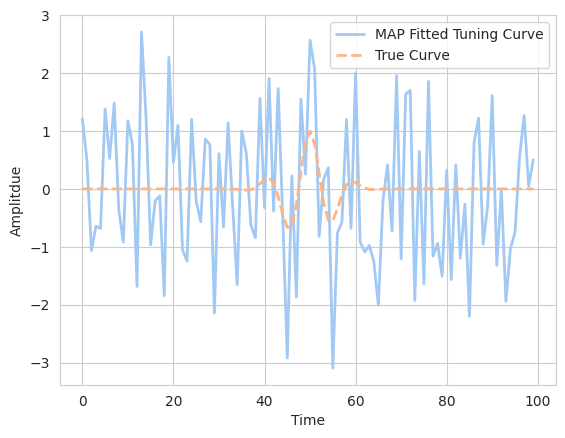

In [20]:
fig = plt.figure()
ax = fig.gca()


sns.lineplot(resultMAP.x, linewidth=2.0, label="MAP Fitted Tuning Curve", ax=ax)
sns.lineplot(true_g, linestyle = '--', linewidth=2.0, label="True Curve", ax=ax)
ax.set_xlabel("time")
ax.set_ylabel('ampltidue')

ax.legend()

ax.set_xlabel("Time")
ax.set_ylabel("Amplitdue")

plt.show()

### How does this change the optimization? 

The addition of the prior increases the computational time but it maks the estimate more accurate for a smaller number of samples. 

### How about the estimated tuning curve?
For the Poisson case, add a “smoothing” term $ p(\nabla g) \sim \mathcal{N}(0, \sigma^2I) $ (following the same procedure).


### How does this affect the optimization? How about the estimated tuning curve?


# Part E

Part E Parameter regimes: Finally you should have code that generates a number of samples $ M $
that probe an $ N $ dimensional receptive field. You should be able to change these parameters as
well as the stimulus strength $ A $ (multiplier of $ X $) as well as the level of regularization (i.e., the
variance of the prior $ \sigma $). Vary these parameters. What happens at low signal levels? How many
samples do you need if $ A = 0.01 $? Compare these observations with the histograms of the spike
counts.
